In [23]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
from sklearn.preprocessing import OneHotEncoder
from pyod.models.hbos import HBOS
from pyod.models.combination import aom, moa, average, maximization

## 1. Lectura base de datos

In [50]:
data_path = r"D:\DANE - Contrato\2024\Operativo Barrido\Data"
emicron = pd.read_csv(os.path.join(data_path,"emicron_establecimientos.csv"),header = 0)
emicron = emicron[emicron['OLA']==2022].reset_index(drop=True)
emicron.drop('OLA',axis=1,inplace=True)

#### One-hot encoding

In [51]:
emicron_ohe = emicron.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())
#drop_enc_df.drop('COD_DEPTO_5', axis=1, inplace = True) # Utilizar como categoría de referencia 5: Antioquia

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_ubi = OneHotEncoder().fit(emicron_ohe[['UBICA']])
drop_enc = ohe_ubi.transform(emicron_ohe[['UBICA']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_ubi.get_feature_names_out())
drop_enc_df.drop('UBICA_3', axis=1, inplace = True)  # Utilizar como categoría de referencia 3: Vivienda (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())
#drop_enc_df.drop('GRUPOS4_2', axis=1, inplace = True) # Utilizar como categoría de referencia 2: Industria Manufacturera

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_conta = OneHotEncoder().fit(emicron_ohe[['REG_CONT']])
drop_enc = ohe_conta.transform(emicron_ohe[['REG_CONT']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_conta.get_feature_names_out())
#drop_enc_df.drop('REG_CONT_4', axis=1, inplace = True) # Utilizar como categoría de referencia 4: No lleva registros (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [52]:
emicron_ohe.drop(['COD_DEPTO','UBICA','GRUPOS4','REG_CONT'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

## 2. Implementación

In [28]:
n_bins = 50
hbos = HBOS(n_bins = n_bins, contamination = 0.05)
hbos.fit(emicron_ohe)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

In [29]:
print("El umbral para los datos de ratio contaminados: ", hbos.threshold_)

El umbral para los datos de ratio contaminados:  -174.1943442943894


In [30]:
scores = hbos.decision_function(emicron_ohe)
pred = hbos.predict(emicron_ohe)

In [31]:
emicron['Anomaly'] = pred

In [32]:
emicron['Anomaly'].value_counts()

0    21642
1     1140
Name: Anomaly, dtype: int64

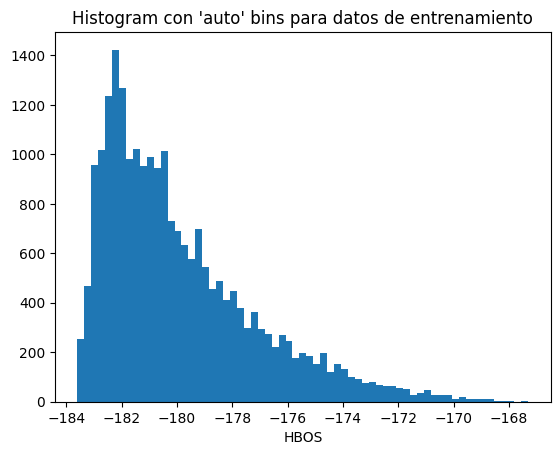

In [33]:
plt.hist(scores, bins = 'auto')
plt.title("Histogram con 'auto' bins para datos de entrenamiento")
plt.xlabel('HBOS')
plt.show()

In [34]:
threshold = hbos.threshold_

In [73]:
np.percentile(np.sort(scores), 95) 

-174.1943442943894

In [18]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)

In [35]:
descriptive_stat_threshold(emicron_ohe, scores, threshold)

,Group,Count,Count %,VENTAS_MES_ANTERIOR,POTTOT,REMUNERACION_TOTAL,CYG,CPAM,IDRUT,CAMCOMER,...,COD_DEPTO_88,UBICA_1,GRUPOS4_2,GRUPOS4_3,GRUPOS4_4,REG_CONT_1,REG_CONT_2,REG_CONT_3,REG_CONT_4,Anomaly_Score
0,Normal,21642,94.99605,3382168.12,0.36,200451.71,2264294.60,0.72,0.40,0.27,...,0.01,0.41,0.14,0.49,0.37,0.02,0.10,0.41,0.47,-180.28
1,Outlier,1140,5.00395,18929701.04,3.00,3655481.36,13228565.86,0.70,0.99,0.96,...,0.06,0.88,0.28,0.32,0.39,0.53,0.36,0.10,0.01,-172.44


### 2.1 Definición umbral promedio

In [67]:
# Generando diez modelos HBOS por rangos de 5, 10, 15, 20, 25, 30, 50, 60, 70 y 100 bins
# testando el rango de agrupaciones (binning)
k_list = [5,10,15,20,25,30,50,60,75,100]
n_clf = len(k_list)
# Se crea un dataframe vacío para los datos de entrenamiento y de test para almacenar las predicciones. Habrá diez modelos por lo que el data frame tendrá 10 columnas
#Almacenar los resultados
scores_mult = np.zeros([emicron_ohe.shape[0], n_clf])

# Modelando

for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins = k)
    hbos.fit(emicron_ohe)
    # Almacenando los resultados en cada columna
    scores_mult[:, i] = hbos.decision_function(emicron_ohe)

In [68]:
scores_mult

array([[ -59.61306025,  -95.27759892, -116.56226003, ..., -190.00710119,
        -201.88065427, -217.19915378],
       [ -60.27342149,  -95.95126329, -117.24048034, ..., -190.69227378,
        -202.56629549, -217.88526428],
       [ -60.27342149,  -94.48286101, -115.67853975, ..., -188.96234041,
        -200.82370871, -216.12981557],
       ...,
       [ -61.71473805,  -97.38930924, -118.67414995, ..., -192.11484165,
        -203.98788717, -219.30584606],
       [ -61.59735897,  -97.26979257, -118.55390429, ..., -191.99348662,
        -203.86645751, -219.18434166],
       [ -57.00880645,  -92.27269934, -113.27980193, ..., -183.70924567,
        -197.95097962, -210.1703444 ]])

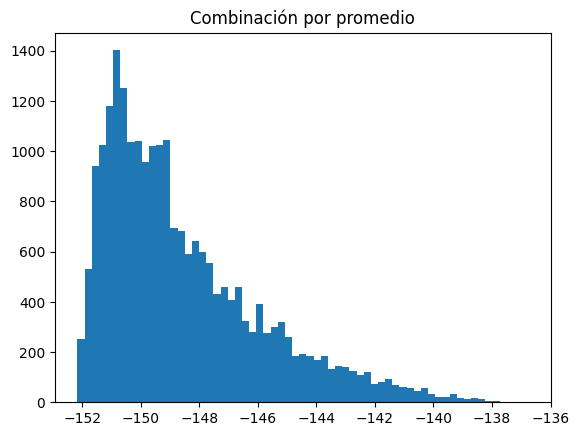

In [69]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_by_average = average(scores_mult)
plt.hist(Y_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [87]:
threshold = np.percentile(np.sort(Y_by_average), 90) 

In [88]:
# Dado que el histograma anterior sugiere que el umbral esté por encima de 4.2, este será el umbral para categorizar lo valores anómalos
descriptive_stat_threshold(emicron_ohe, Y_by_average, threshold)

,Group,Count,Count %,VENTAS_MES_ANTERIOR,POTTOT,REMUNERACION_TOTAL,CYG,CPAM,IDRUT,CAMCOMER,...,COD_DEPTO_88,UBICA_1,GRUPOS4_2,GRUPOS4_3,GRUPOS4_4,REG_CONT_1,REG_CONT_2,REG_CONT_3,REG_CONT_4,Anomaly_Score
0,Normal,20503,89.996488,3023525.38,0.29,143750.20,2013378.17,0.72,0.37,0.24,...,0.01,0.38,0.13,0.50,0.37,0.01,0.08,0.42,0.49,-149.23
1,Outlier,2279,10.003512,14385871.34,2.29,2438839.03,10006202.76,0.67,0.97,0.93,...,0.04,0.84,0.25,0.36,0.38,0.38,0.39,0.19,0.04,-142.65


In [89]:
hbos_res = descriptive_stat_threshold(emicron, Y_by_average, threshold, 2)

In [90]:
hbos_res.to_csv(os.path.join(data_path,"fijos_hbos_res.csv"), index = False)